# RieCUR

Paper: https://arxiv.org/pdf/2206.09042.pdf

Related paper on IRCUR: https://arxiv.org/pdf/2010.07422.pdf

In [31]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(precision=3, sci_mode=True)

In [32]:
## ======================== Parameters ========================
d1 = 1000                   # num. of rows
d2 = 700                   # num. of columns
max_iter = 100              # num. of layers trained
r = 2
alpha = 0.65

In [3]:
## Code to generate data for RPCA problem. References:
## https://github.com/caesarcai/LRPCA/blob/main/synthetic_data_exp/training_codes.py 
## https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/test_AccAltProj.m

def generate_problem(r,d1,d2,alpha, c):
    U0_t 		= torch.randn(d1,r)
    V0_t 		= torch.randn(d2,r)
    L0_t 		= U0_t @ V0_t.t()
    idx 		= torch.randperm(d1*d2)
    idx 		= idx[:math.floor(alpha * d1*d2)]
    s_range		= c * torch.mean(torch.abs(L0_t))
    S0_tmp 		= torch.rand(d1 * d2)
    S0_tmp 		= s_range * (2.0 * S0_tmp - 1.0)
    S0_t        = torch.zeros(d1 * d2)
    S0_t[idx]   = S0_tmp[idx]
    S0_t        = S0_t.reshape((d1,d2))
    Y0_t        = L0_t + S0_t
    return L0_t, S0_t, Y0_t

## Classical

In [27]:
def thres(inputs, threshold, hard=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
    else:
        out = torch.sign(inputs) * (nn.Threshold(threshold, 0)(torch.abs(inputs)))
    return out

## resampling function
def resample(m, n, siz_row, siz_col):
    rows = np.random.randint(0, m, size=[1, siz_row])
    cols = np.random.randint(0, n, size=[1, siz_col])
    return [np.unique(rows), np.unique(cols)]

## convert CUR to SVD; input L = C @ pinv_U @ R, output L = W @ torch.diag(Sigma) @ V.t()
## ref: Algorithm 2, page 6, IRCUR paper https://arxiv.org/pdf/2010.07422.pdf
def cur_to_svd(C, pinv_U, R, r):
    Qc, Rc = torch.linalg.qr(C)
    Qr, Rr = torch.linalg.qr(R.t())
    Wu, Sigma, Vuh = torch.linalg.svd(Rc @ pinv_U @ Rr.t(), full_matrices=False)
    W = Qc @ Wu
    V = Qr @ Vuh.t()
    return W[:, :r], Sigma[:r], V[:, :r]

def RieCUR(M0, r, tol, gamma, con, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)

    ## Compute S_{-1}
    beta = 1/(2 * np.power(m * n, 1/4))
    beta_init = 4 * beta
    zeta = beta_init * torch.linalg.norm(M0, 2)
    S = thres(M0, zeta)
    ## Compute L_0 by CUR decomposition
    rows, cols = resample(m, n, siz_row, siz_col)
    C = M0[:, cols] - S[:, cols]
    R = M0[rows, :] - S[rows, :]
    MU = C[rows, :]
    U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
    pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
    L = C @ pinv_U @ R
    ## Compute S_0
    W, Sigma, V = cur_to_svd(C, pinv_U, R, r)
    zeta = beta * Sigma[0]
    S = thres(M0 - L, zeta)

    zeta = torch.max(torch.abs(M0))
    for t in range(max_iter):
        ## resample rows and columns
        rows, cols = resample(m, n, siz_row, siz_col)
        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        ## update L
        W, Sigma, V = cur_to_svd(C, pinv_U, R, r)
        Rt, Ct = R @ V @ V.t(), W @ W.t() @ C
        C, R = [Ct @ pinv_U @ (R[:, cols] - Rt[:, cols]) + C @ pinv_U @ Rt[:, cols], 
                Ct[rows, :] @ pinv_U @ R + (C[rows, :] - Ct[rows, :]) @ pinv_U @ R]
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        ## update S using submatrices of L
        S_rows = thres(M0_rows - L_rows, zeta)
        S_cols = thres(M0_cols - L_cols, zeta)
        ## update zeta
        zeta = gamma * zeta
        ## update loss
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        loss.append(err)
        if err < tol:
            L = C @ pinv_U @ R
            S = M0 - L
            return loss, L, S
    L = C @ pinv_U @ R
    S = M0 - L
    return loss, L, S

In [33]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [34]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.7, sampling constant = 3, max_iter = 100
loss, L_hat, S_hat = RieCUR(M_true, r, 1e-6, torch.tensor(0.7), 3, max_iter)

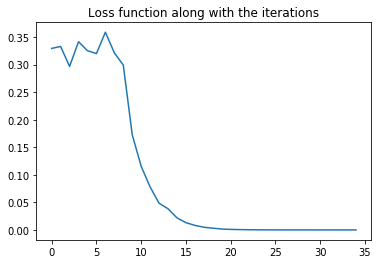

tensor(5.324e-07)
tensor(1.217e-01)
tensor(9.107e-01)


In [35]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

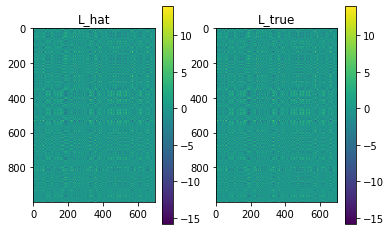

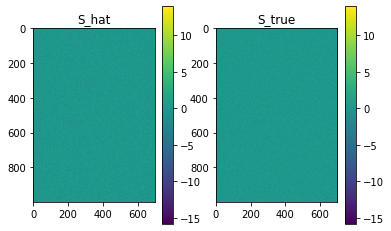

In [36]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(L_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
plt.show()

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(S_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
plt.show()